# Kết nối và tải các thư viện

In [ ]:
# 1. Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cài đặt thư viện cần thiết
    !pip install transformers torch pandas scikit-learn seaborn matplotlib tqdm

Mounted at /content/drive


# Cấu hình và kiểm tra GPU

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm

# ================= CẤU HÌNH ĐƯỜNG DẪN =================
# Đường dẫn thư mục trên Drive
PROJECT_PATH = '/content/drive/MyDrive/FakeNewsProject'

# File đầu vào và đầu ra
INPUT_FILE = os.path.join(PROJECT_PATH, 'articles_clean.csv')
SAVE_PATH = os.path.join(PROJECT_PATH, 'phobert_classifier.pth')
MODEL_NAME = "vinai/phobert-base"

# ================= HYPERPARAMETERS =================
MAX_LEN = 128       # 128 là đủ cho tin tức (Max là 256)
BATCH_SIZE = 32     # Nếu lỗi tràn RAM (OOM), giảm xuống 16
EPOCHS = 3          # Số vòng học
LEARNING_RATE = 2e-5
SAMPLE_SIZE = None  # Để None để chạy Full. Đặt 5000 nếu muốn test nhanh.

# Kiểm tra GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'✅ Đã tìm thấy GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('⚠️ CẢNH BÁO: Không tìm thấy GPU. Hãy bật GPU trong Runtime Settings!')

⚠️ CẢNH BÁO: Không tìm thấy GPU. Hãy bật GPU trong Runtime Settings!


# Làm sạch dữ liệu 
- Nếu dữ liệu đã sạch bỏ qua bước này 

In [ ]:
import re
import pandas as pd

# 1. Load dữ liệu cũ
file_path = '/content/drive/MyDrive/FakeNewsProject/articles_clean.csv' # Sửa đường dẫn nếu cần
df = pd.read_csv(file_path)

# Xác định lại tên cột
col_text = 'content' # Hoặc tên cột đúng của bạn
col_label = 'label'

print("Đang chuẩn hóa văn bản...")

# 2. Hàm chuẩn hóa (Regex Cleaning)
def normalize_text(text):
    if not isinstance(text, str):
        return ""

    # Bước 1: Xóa khoảng trắng thừa trước dấu câu (, . : ; ! ?)
    # Ví dụ: "Xin chào , tôi là AI ." -> "Xin chào, tôi là AI."
    text = re.sub(r'\s+([.,;?!:])', r'\1', text)

    # Bước 2: Xóa khoảng trắng quanh dấu gạch chéo (để sửa lỗi ngày tháng)
    # Ví dụ: "10 / 11" -> "10/11"
    text = re.sub(r'(\d)\s+/\s+(\d)', r'\1/\2', text)

    # Bước 3: Xóa khoảng trắng thừa giữa các dấu ngoặc ngoặc kép " ... " -> "..."
    text = re.sub(r'\s+([")])', r'\1', text) # Xóa space trước đóng ngoặc
    text = re.sub(r'([("])\s+', r'\1', text) # Xóa space sau mở ngoặc

    # Bước 4: Chuyển về chữ thường (Optional - Tùy chọn, PhoBERT cased thì không cần)
    # text = text.lower()

    # Bước 5: Xóa các nguồn tin hay lộ (Regex nâng cao)
    # Xóa các cụm như: "TP HCM -", "HÀ NỘI -", "(VTV) -" ở đầu câu
    text = re.sub(r'^[A-ZĐÀ-Ỹ ]+\s*-\s*', '', text)

    return text.strip()

# 3. Áp dụng vào dữ liệu
# Lưu ý: Sẽ mất khoảng 30s - 1 phút
df[col_text] = df[col_text].apply(normalize_text)

# 4. Kiểm tra lại kết quả
print("\n--- SAU KHI SỬA LỖI (Check lại Tin Giả) ---")
fake_samples = df[df[col_label] == 0][col_text].sample(5).values
for i, text in enumerate(fake_samples):
    print(f"[{i+1}] {text[:100]}...")

# 5. Lưu đè lên file cũ để Train lại
df.to_csv(file_path, index=False)
print(f"\n✅ Đã lưu file đã làm sạch vào: {file_path}")
print("👉 Hãy quay lại bước Train Model để thấy Accuracy giảm xuống mức thực tế!")

Đang chuẩn hóa văn bản...

--- SAU KHI SỬA LỖI (Check lại Tin Giả) ---
[1] Nội dung được nêu trong văn bản của cơ quan này gửi Bộ Giáo dục và Đào tạo, ngày 11/4. Lý do là các ...
[2] Nhà báo Nguyễn Hữu Vinh (Anh Ba Sàm) đang đối mặt với một số diễn biến bất thường tại Trại giam số 5...
[3] Tôi năm nay 24 tuổi. đã lập gia đình được 4 năm và có bé trai hai tuổi. Công ty tôi có đồng nghiệp n...
[4] Trong hơn một thập kỷ, ông Kazuhide Inoue, 58 tuổi, đã âm thầm bảo vệ trẻ em ở Fukuoka, khi thường x...
[5] "Trong cuộc hội đàm với trợ lý Bộ trưởng Quốc phòng Mỹ Ely Ratner, Đại sứ Tạ Phong đã thảo luận về q...

✅ Đã lưu file đã làm sạch vào: /content/drive/MyDrive/FakeNewsProject/articles_clean.csv
👉 Hãy quay lại bước Train Model để thấy Accuracy giảm xuống mức thực tế!


# Đọc và kiểm tra dataset

In [ ]:
# 1. Đọc file
print(f"📂 Đang đọc file từ: {INPUT_FILE}")
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"❌ Không tìm thấy file. Hãy kiểm tra lại thư mục 'FakeNewsProject' trên Drive!")

df = pd.read_csv(INPUT_FILE)

# 2. Tự động tìm tên cột
col_text = next((c for c in ['content', 'text', 'news', 'body'] if c in df.columns), None)
col_label = next((c for c in ['label', 'target', 'is_fake'] if c in df.columns), None)

if not col_text or not col_label:
    raise ValueError(f"❌ Không tìm thấy tên cột. Các cột hiện có: {list(df.columns)}")

print(f"✅ Cột nội dung: '{col_text}' | Cột nhãn: '{col_label}'")

# 3. Lấy mẫu (nếu cần test nhanh)
if SAMPLE_SIZE and SAMPLE_SIZE < len(df):
    print(f"⚠️ Đang lấy mẫu ngẫu nhiên {SAMPLE_SIZE} dòng để test code...")
    df = df.sample(SAMPLE_SIZE, random_state=42)

texts = df[col_text].values
labels = df[col_label].values

print(f"📊 Tổng số mẫu dùng để train: {len(texts)}")

📂 Đang đọc file từ: /content/drive/MyDrive/FakeNewsProject/articles_clean.csv
✅ Cột nội dung: 'content' | Cột nhãn: 'label'
📊 Tổng số mẫu dùng để train: 96239


# Tokenizer dữ liệu

In [ ]:
print("🤖 Đang tải Tokenizer PhoBERT...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_batch(data_texts, max_len=128):
    input_ids = []
    attention_masks = []

    # Dùng list comprehension cho nhanh
    print("🚀 Đang mã hóa dữ liệu...")
    for text in tqdm(data_texts):
        encoded = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Thực hiện mã hóa
input_ids, attention_masks = encode_batch(texts, MAX_LEN)
labels = torch.tensor(labels)
print("✅ Mã hóa hoàn tất.")

🤖 Đang tải Tokenizer PhoBERT...
🚀 Đang mã hóa dữ liệu...


  0%|          | 0/96239 [00:00<?, ?it/s]

✅ Mã hóa hoàn tất.


# Tách dataset 
- Train 85% và validation 15%

In [ ]:
# Chia train (85%) - validation (15%)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.15, stratify=labels
)
train_masks, val_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.15, stratify=labels
)

# Tạo DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

print(f"🔹 Train set: {len(train_inputs)}")
print(f"🔹 Val set:   {len(val_inputs)}")

🔹 Train set: 81803
🔹 Val set:   14436


# Load Model

In [ ]:
class PhoBertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(PhoBertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 2) # Output 2 lớp: Fake(0), Real(1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

model = PhoBertClassifier(freeze_bert=False) # False để học kỹ, True để học nhanh
model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()

print("✅ Model đã sẵn sàng trên GPU.")

✅ Model đã sẵn sàng trên GPU.


# Bắt đầu Train model

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Setup seed
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

training_stats = []

print("🚀 BẮT ĐẦU TRAINING...")

for epoch_i in range(0, EPOCHS):
    print(f'\n======== Epoch {epoch_i + 1} / {EPOCHS} ========')

    # --- TRAINING ---
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Thanh progress bar
    progress = tqdm(train_dataloader, desc=f"Epoch {epoch_i+1} Train")

    for step, batch in enumerate(progress):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        logits = model(b_input_ids, b_input_mask)
        loss = loss_fn(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_dataloader)

    # --- VALIDATION ---
    print("Running Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    val_preds = []
    val_true = []

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            logits = model(b_input_ids, b_input_mask)
            loss = loss_fn(logits, b_labels)

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        val_preds.extend(np.argmax(logits, axis=1).flatten())
        val_true.extend(label_ids.flatten())

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    print(f"  ✅ Avg Train Loss: {avg_train_loss:.4f}")
    print(f"  ✅ Avg Val Loss:   {avg_val_loss:.4f}")
    print(f"  ✅ Val Accuracy:   {avg_val_accuracy:.4f}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'val_preds': val_preds, # Lưu lại để vẽ Confusion Matrix
        'val_true': val_true
    })

print("\n🏁 TRAINING COMPLETE!")

# Lưu model vào Drive
print(f"💾 Đang lưu model vào Drive: {SAVE_PATH}")
torch.save(model.state_dict(), SAVE_PATH)
print("✅ Đã lưu thành công!")

🚀 BẮT ĐẦU TRAINING...

======== Epoch 1 / 3 ========


Epoch 1 Train:   0%|          | 0/2557 [00:00<?, ?it/s]

Running Validation...
  ✅ Avg Train Loss: 0.1224
  ✅ Avg Val Loss:   0.0864
  ✅ Val Accuracy:   0.9705

======== Epoch 2 / 3 ========


Epoch 2 Train:   0%|          | 0/2557 [00:00<?, ?it/s]

Running Validation...
  ✅ Avg Train Loss: 0.0721
  ✅ Avg Val Loss:   0.0767
  ✅ Val Accuracy:   0.9703

======== Epoch 3 / 3 ========


Epoch 3 Train:   0%|          | 0/2557 [00:00<?, ?it/s]

Running Validation...
  ✅ Avg Train Loss: 0.0516
  ✅ Avg Val Loss:   0.0810
  ✅ Val Accuracy:   0.9728

🏁 TRAINING COMPLETE!
💾 Đang lưu model vào Drive: /content/drive/MyDrive/FakeNewsProject/phobert_classifier.pth
✅ Đã lưu thành công!


# Evaluate mô hình sau khi train

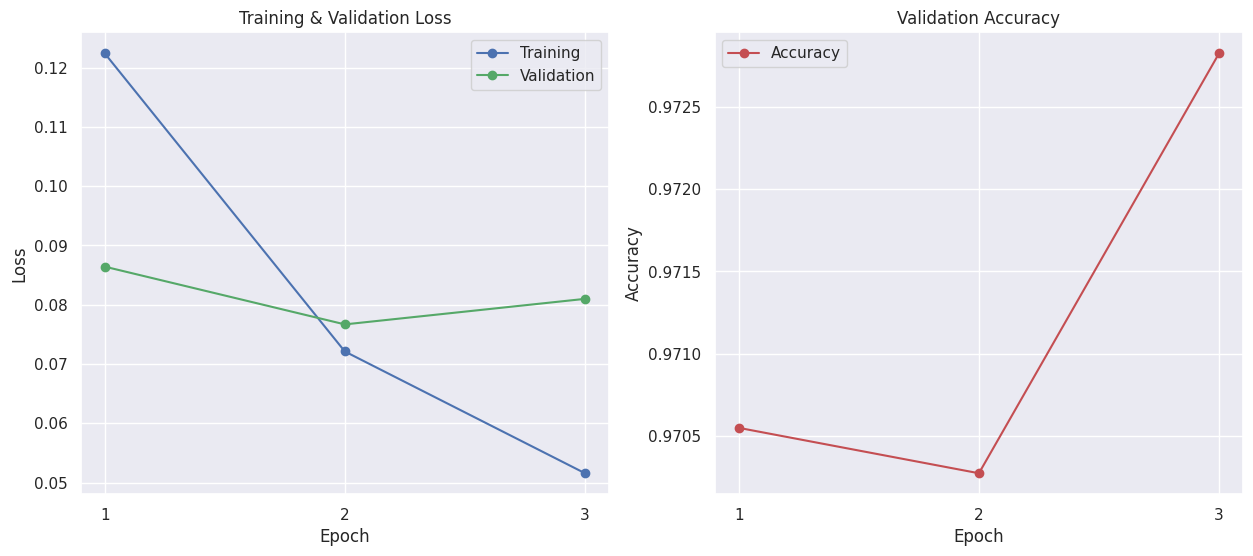

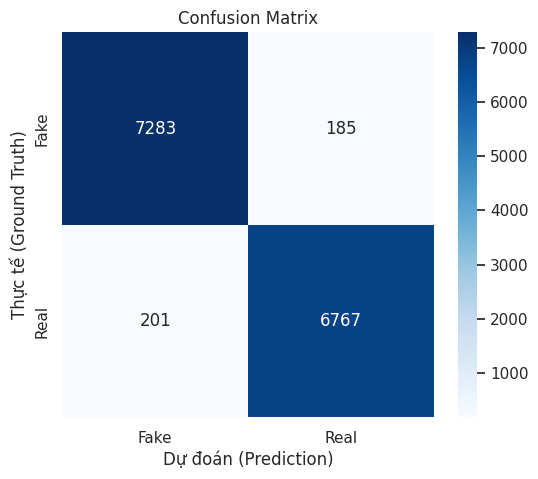

              precision    recall  f1-score   support

        Fake       0.97      0.98      0.97      7468
        Real       0.97      0.97      0.97      6968

    accuracy                           0.97     14436
   macro avg       0.97      0.97      0.97     14436
weighted avg       0.97      0.97      0.97     14436



In [ ]:
# Cấu hình biểu đồ
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (15,6)

# Tạo DataFrame
df_stats = pd.DataFrame(data=training_stats)

# 1. Vẽ Learning Curve
plt.subplot(1, 2, 1)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index, df_stats['epoch'])

# 2. Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(df_stats.index, df_stats['epoch'])

plt.show()

# 3. Vẽ Confusion Matrix (Của Epoch cuối cùng)
last_epoch_data = training_stats[-1]
cm = confusion_matrix(last_epoch_data['val_true'], last_epoch_data['val_preds'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.ylabel('Thực tế (Ground Truth)')
plt.xlabel('Dự đoán (Prediction)')
plt.title('Confusion Matrix')
plt.show()

# In báo cáo chi tiết
print(classification_report(last_epoch_data['val_true'], last_epoch_data['val_preds'], target_names=['Fake', 'Real']))

# Testing model

In [3]:
def predict_news_logic(text, threshold=0.80):
    model.eval()
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Predict
    with torch.no_grad():
        logits = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.nn.functional.softmax(logits, dim=1)

    fake_prob = probs[0][0].item()
    real_prob = probs[0][1].item()

    print(f"\n📰 Input: {text[:80]}...")
    print(f"📊 Xác suất: Real={real_prob:.2%} | Fake={fake_prob:.2%}")

    # LOGIC 3 TRẠNG THÁI
    if real_prob > threshold:
        return "✅ 1 (REAL)"
    elif fake_prob > threshold:
        return "❌ 0 (FAKE)"
    else:
        return "⚠️ 2 (UNDEFINED - Cần kiểm tra thêm)"

# --- TEST THỬ ---
test_1 = "Bộ Y tế khuyến cáo người dân thực hiện quy tắc 5K."
test_2 = "Người ngoài hành tinh vừa đáp xuống Hồ Gươm ăn kem."
test_3 = "Chính phủ đang xem xét một vài chính sách mới chưa được công bố." # Câu này có thể gây lưỡng lự

print(f"Kết quả: {predict_news_logic(test_1)}")
print(f"Kết quả: {predict_news_logic(test_2)}")
print(f"Kết quả: {predict_news_logic(test_3)}")

NameError: name 'model' is not defined

# Kiểm tra xem dữ liệu có chuẩn không 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load lại dữ liệu
df = pd.read_csv('/content/drive/MyDrive/FakeNewsProject/articles_clean.csv')

# Đổi tên cột cho chuẩn (đề phòng)
col_text = next((c for c in ['content', 'text', 'news'] if c in df.columns), None)
col_label = next((c for c in ['label', 'target'] if c in df.columns), None)

print(f"🔍 Đang soi dữ liệu từ cột: {col_text}")

# 2. IN RA 5 MẪU ĐỂ SO I BẰNG MẮT THƯỜNG (Quan trọng nhất)
print("\n=== 5 MẪU TIN THẬT (REAL - Label 1) ===")
real_samples = df[df[col_label] == 1][col_text].sample(5).values
for i, text in enumerate(real_samples):
    print(f"[{i+1}] {text[:150]}...") # Chỉ in 150 ký tự đầu

print("\n=== 5 MẪU TIN GIẢ (FAKE - Label 0) ===")
fake_samples = df[df[col_label] == 0][col_text].sample(5).values
for i, text in enumerate(fake_samples):
    print(f"[{i+1}] {text[:150]}...")

# 3. TÌM TỪ KHÓA XUẤT HIỆN NHIỀU NHẤT (Top Keywords)
def get_top_n_words(corpus, n=None):
    # Fill NaN values with empty strings to prevent ValueError in CountVectorizer
    corpus = corpus.fillna('').astype(str)
    vec = CountVectorizer(stop_words=['và', 'của', 'là', 'có', 'những', 'được', 'trong', 'với'], max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy top 20 từ của Real và Fake
common_words_real = get_top_n_words(df[df[col_label] == 1][col_text], 20)
common_words_fake = get_top_n_words(df[df[col_label] == 0][col_text], 20)

df1 = pd.DataFrame(common_words_real, columns=['ReviewText', 'count'])
df2 = pd.DataFrame(common_words_fake, columns=['ReviewText', 'count'])

print("\n=== TOP 20 TỪ XUẤT HIỆN TRONG TIN THẬT ===")
print(df1['ReviewText'].tolist())

print("\n=== TOP 20 TỪ XUẤT HIỆN TRONG TIN GIẢ ===")
print(df2['ReviewText'].tolist())

# 4. KIỂM TRA ĐỘ DÀI
df['len'] = df[col_text].apply(lambda x: len(str(x).split()))
avg_real = df[df[col_label] == 1]['len'].mean()
avg_fake = df[df[col_label] == 0]['len'].mean()

print(f"\n=== ĐỘ DÀI TRUNG BÌNH ===")
print(f"Tin thật: {avg_real:.1f} từ")
print(f"Tin giả:  {avg_fake:.1f} từ")

🔍 Đang soi dữ liệu từ cột: content

=== 5 MẪU TIN THẬT (REAL - Label 1) ===
[1] Theo đại diện UBND huyện Cô Tô, một số doanh nghiệp Hàn Quốc đã liên hệ với UBND huyện về việc khảo sát xây dựng tour lặn biển tại đảo Thanh Lân. Việc...
[2] Đến 6/2, có 258 sàn thương mại điện tử, gồm Shopee, Lazada, Sendo (chưa gồm Tiki) đã cung cấp thông tin của người bán trên cổng thông tin thương mại đ...
[3] Báo cáo thường niên của Kelley Blue Book (KBB) - một trong những hãng đánh giá giá trị ôtô lớn nhất Mỹ - cho thấy xu hướng tiêu dùng của người Mỹ khi ...
[4] Kota Kai, chủ tiệm ramen Debu-chan ở Tokyo, tính thời gian khách hàng ăn. Sau đó, ông phát hiện những người ngồi lâu nhất thường vừa ăn vừa xem điện t...
[5] Theo Ifeng tối 23/2, công ty của người đẹp thay đổi thông tin đăng ký. Theo đó, đại diện pháp nhân, CEO và cổ đông lớn nhất của Công ty văn hóa Tử Thấ...

=== 5 MẪU TIN GIẢ (FAKE - Label 0) ===
[1] Một trong những điểm phản biện thường thấy trong các thảo luận liên quan đến tình hình tha